In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from scipy.ndimage import gaussian_filter1d

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(1)
cluster = PBSCluster(cores=28, processes=14, walltime='01:30:00')
w = cluster.scale(2*14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.66:50167 Dashboard: http://10.148.1.66:8787/status,Cluster Workers: 14 Cores: 28 Memory: 119.98 GB


____________
## 1.Read AVISO data
### Global scale for two years (2012.01.01-2013.12.31; daily resolution)

In [4]:
# Read data
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
ds = xr.open_zarr(out_dir_zarr+'AVISO_uv_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

 data size: 12.1 GB


In [5]:
# Grid

ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
grid = Grid(ds_full, periodic=['X','Y'])

dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360)
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)
dlatg[0]=0.25
dlatc[-1]=0.25

In [6]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [7]:
ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.lon, ds_full.lat)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.lon, ds_full.lat)
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyg       (lon, lat_left) float32 27750.0 27750.0 ... 27750.0 27750.0
    dxc       (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc       (lon, lat) float32 27750.0 27750.0 27750.0 ... 27750.0 27750.0
    area_c    (lon, lat) float32 1680063.0 5040041.0 ... 5040041.0 1680063.0
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v    

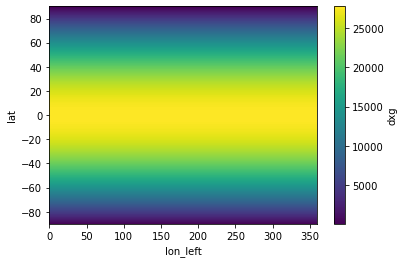

In [8]:
# dx (varis with latitude)
ds_full.dxg.plot(x='lon_left',y='lat')

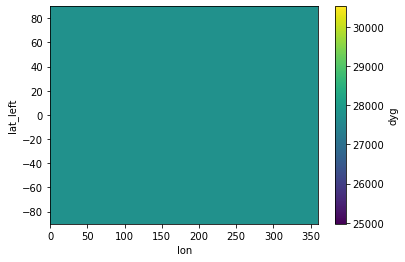

In [9]:
# dy (constant distance about 28km)
ds_full.dyg.plot(x='lon',y='lat_left')

## Horizontal gradients for velocity

In [10]:
du_dx = grid.diff(ds_full.u.where(ds.u>-20), 'X') / ds_full.dxg
du_dx_ij = grid.interp(du_dx, 'X')
du_dx_ij = np.real(du_dx_ij).rename('du_dx_ij') 
du_dx_ij

<xarray.DataArray 'du_dx_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [11]:
du_dy = grid.diff(ds_full.u.where(ds.u>-20), 'Y') / ds_full.dyg
du_dy_ij = grid.interp(du_dy, 'Y')
du_dy_ij = np.real(du_dy_ij).rename('du_dy_ij') 
du_dy_ij

<xarray.DataArray 'du_dy_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [12]:
dv_dx = grid.diff(ds_full.v.where(ds.u>-20), 'X') / ds_full.dxg
dv_dx_ij = grid.interp(dv_dx, 'X')
dv_dx_ij = np.real(dv_dx_ij).rename('dv_dx_ij') 
dv_dx_ij

<xarray.DataArray 'dv_dx_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [13]:
dv_dy = grid.diff(ds_full.v.where(ds.u>-20), 'Y') / ds_full.dyg
dv_dy_ij = grid.interp(dv_dy, 'Y')
dv_dy_ij = np.real(dv_dy_ij).rename('dv_dy_ij') 
dv_dy_ij

<xarray.DataArray 'dv_dy_ij' (time: 731, lat: 720, lon: 1440)>
dask.array<real, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [14]:
# define (real) time
def iters_to_date(iters, delta_t=24*3600.):
    t0 = datetime.datetime(2012,1,1)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [15]:
time_day = iters_to_date(np.arange(731))

In [16]:
# data for the coarse-graining approach
ds_cg = xr.merge([ds_full, du_dx_ij, du_dy_ij, dv_dx_ij, dv_dy_ij])
ds_cg = ds_cg.assign_coords(time=time_day) 
print(ds_cg)

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyg       (lon, lat_left) float32 27750.0 27750.0 ... 27750.0 27750.0
    dxc       (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc       (lon, lat) float32 27750.0 27750.0 27750.0 ... 27750.0 27750.0
    area_c    (lon, lat) float32 1680063.0 5040041.0 ... 5040041.0 1680063.0
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v    

In [17]:
# Rechunk (no chunks along time)
chunks = {'lat': 72, 'lon': 72, 'time':731}            
ds_cg = ds_cg.chunk(chunks)
#ds_cg = ds_cg.isel(time=slice(248,613))
ds_cg

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 dask.array<chunksize=(1440, 72), meta=np.ndarray>
    dyg       (lon, lat_left) float32 dask.array<chunksize=(72, 720), meta=np.ndarray>
    dxc       (lon, lat) float32 dask.array<chunksize=(72, 72), meta=np.ndarray>
    dyc       (lon, lat) float32 dask.array<chunksize=(72, 72), meta=np.ndarray>
    area_c    (lon, lat) float32 dask.array<chunksize=(72, 72), meta=np.ndarray>
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(731, 7

In [18]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/AVISO/'

__________
## 2. Coarse-graining

In [19]:
# define gaussian filter 
def gaussianfilter(x, sigma, axis):
    
    return xr.apply_ufunc(gaussian_filter1d, x, sigma, axis,
                          dask='parallelized',
                          output_dtypes=[x.dtype])

In [23]:
from functools import partial
from scipy.signal import butter, filtfilt

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

### a test

In [32]:
a_10 = gaussianfilter(ds_cg.u, sigma=15, axis=0)

In [36]:
lowcut = 1/60

fs = 1
nyq = 0.5*fs
low = lowcut/nyq

b, a = butter(4, low, 'low')

In [37]:
b_10 = butter_filter(ds_cg.u, b, a)

(-0.3, 0.3)

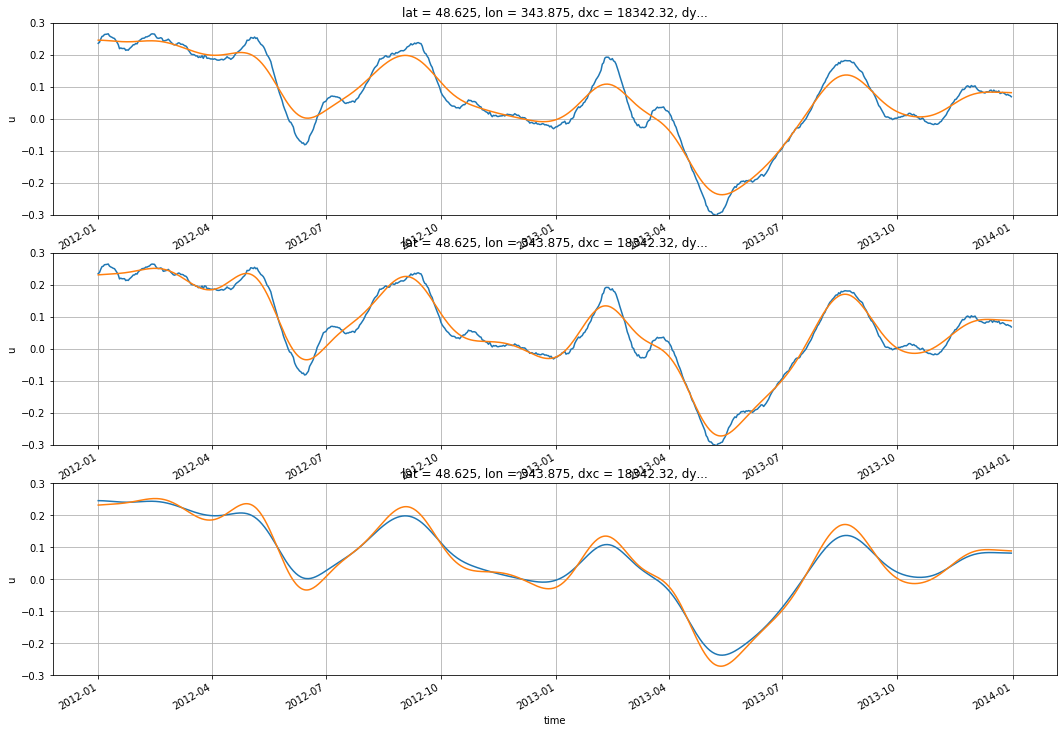

In [38]:
fig, ax = plt.subplots(figsize=(18,12))

ax = plt.subplot(311)
ds_cg.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_10.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
#b_10.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
ax.grid()
ax.set_ylim([-.3, .3])

ax = plt.subplot(312)
ds_cg.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
#a_10.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
b_10.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
ax.grid()
ax.set_ylim([-.3, .3])

ax = plt.subplot(313)
#ds_cg.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_10.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
b_10.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
ax.grid()
ax.set_ylim([-.3, .3])

In [22]:
a_15 = gaussianfilter(ds_cg.u, sigma=15, axis=0)
a_30 = gaussianfilter(ds_cg.u, sigma=30, axis=0)
a_45 = gaussianfilter(ds_cg.u, sigma=45, axis=0)

In [9]:
du_dx = gridx.diff(butter_filter(ds.U, b, a), 'X')/gridx.interp(ds.dxG, 'Y')


<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

(-0.3, 0.3)

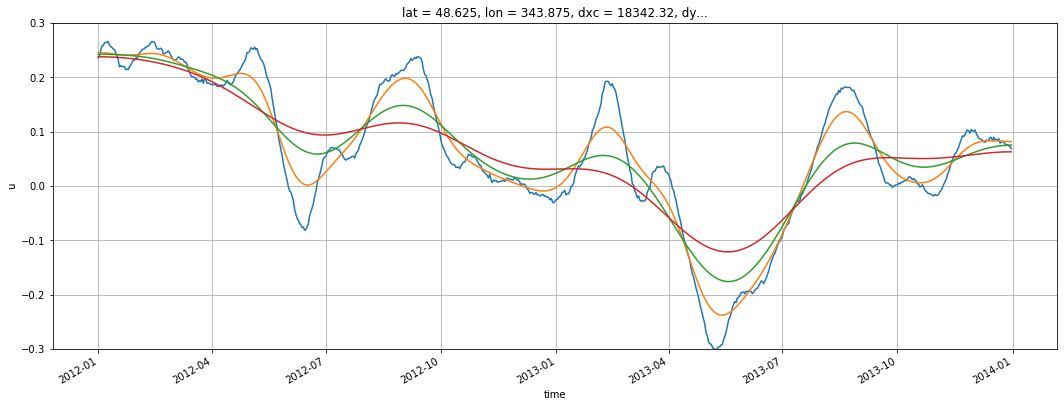

In [23]:
fig, ax = plt.subplots(figsize=(18,6))
ax = plt.subplot(111)
ds_cg.u.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_15.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_30.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
a_45.sel(lat=48.6875,lon=343.8125,method='nearest').plot()
ax.grid()
ax.set_ylim([-.3, .3])

## Calculating $\Pi_\omega$

In [39]:
overwrite=True
    
for sigma in [7,15,22,30]:

    Efile = store_dir_zarr+'PI_cg_sigma_%03d.zarr'%(sigma)

    if not os.path.isdir(Efile) or overwrite:

        PI_1 = ( gaussianfilter(ds_cg.u**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.u, sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.du_dx_ij, sigma=sigma, axis=0)
        PI_2 = ( gaussianfilter(ds_cg.v**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.v, sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.dv_dy_ij, sigma=sigma, axis=0)
        PI_3 = ( gaussianfilter(ds_cg.u*ds_cg.v, sigma=sigma, axis=0) - gaussianfilter(ds_cg.u, sigma=sigma, axis=0) * gaussianfilter(ds_cg.v, sigma=sigma, axis=0) ) * (gaussianfilter(ds_cg.du_dy_ij, sigma=sigma, axis=0)+gaussianfilter(ds_cg.dv_dx_ij, sigma=sigma, axis=0))

        PI_cg = -(PI_1+PI_2+PI_3)

        # store
        PI_cg = np.real(PI_cg).rename('PI_cg')
        PI_cg = PI_cg.to_dataset()        
        
        for c in PI_cg.coords:
            try:
                del PI_cg[c].encoding['chunks']
            except:
                pass
            
        %time PI_cg.to_zarr(Efile, mode='w')

        print('--- sigma %d done'%sigma)

    else:
        print('--- sigma %d allready computed'%sigma)

CPU times: user 52.2 s, sys: 1.51 s, total: 53.8 s
Wall time: 1min
--- sigma 7 done
CPU times: user 52.8 s, sys: 1.27 s, total: 54.1 s
Wall time: 1min 2s
--- sigma 15 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 53.2 s, sys: 1.33 s, total: 54.5 s
Wall time: 1min 2s
--- sigma 22 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 53.3 s, sys: 1.23 s, total: 54.5 s
Wall time: 1min 2s
--- sigma 30 done


In [40]:
PI_cg_sigma_030 = xr.open_zarr(store_dir_zarr+'PI_cg_sigma_007.zarr')
PI_cg_sigma_060 = xr.open_zarr(store_dir_zarr+'PI_cg_sigma_015.zarr')
PI_cg_sigma_090 = xr.open_zarr(store_dir_zarr+'PI_cg_sigma_022.zarr')
PI_cg_sigma_120 = xr.open_zarr(store_dir_zarr+'PI_cg_sigma_030.zarr')

In [41]:
PI_cg_30_cumsum = 3600*24*PI_cg_sigma_030.PI_cg.sel(time=slice('2012-09-05', '2013-09-5')).cumsum(['time'])
PI_cg_60_cumsum = 3600*24*PI_cg_sigma_060.PI_cg.sel(time=slice('2012-09-05', '2013-09-5')).cumsum(['time'])
PI_cg_90_cumsum = 3600*24*PI_cg_sigma_090.PI_cg.sel(time=slice('2012-09-05', '2013-09-5')).cumsum(['time'])
PI_cg_120_cumsum = 3600*24*PI_cg_sigma_120.PI_cg.sel(time=slice('2012-09-05', '2013-09-5')).cumsum(['time'])

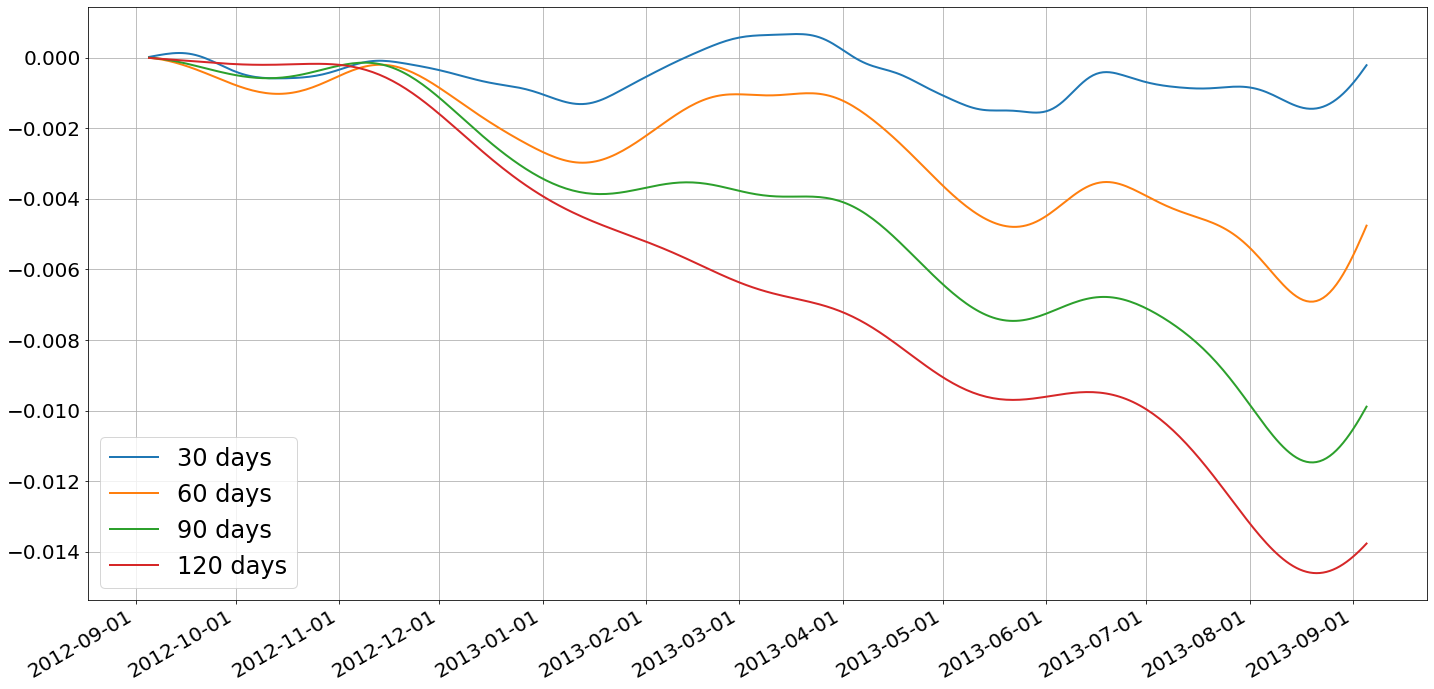

In [43]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(24,24))
labels = ['30 days', '60 days', '90 days','120 days']

ax = plt.subplot(211)
PI_cg_30_cumsum.sel(time=slice('2012-09-05', '2013-09-5'), lat=slice(47.5,50),lon=slice(342,346)).mean(['lat','lon']).plot(label=labels[0], linewidth=2)
PI_cg_60_cumsum.sel(time=slice('2012-09-05', '2013-09-5'), lat=slice(47.5,50),lon=slice(342,346)).mean(['lat','lon']).plot(label=labels[1], linewidth=2)
PI_cg_90_cumsum.sel(time=slice('2012-09-05', '2013-09-5'), lat=slice(47.5,50),lon=slice(342,346)).mean(['lat','lon']).plot(label=labels[2], linewidth=2)
PI_cg_120_cumsum.sel(time=slice('2012-09-05', '2013-09-5'), lat=slice(47.5,50),lon=slice(342,346)).mean(['lat','lon']).plot(label=labels[3], linewidth=2)

ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
#ax.set_ylim([-1.5*1e-8, 1.5*1e-8])
ax.set_xticks(['2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09'])
ax.set_title('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_coarse_graining_long_periods5.png')

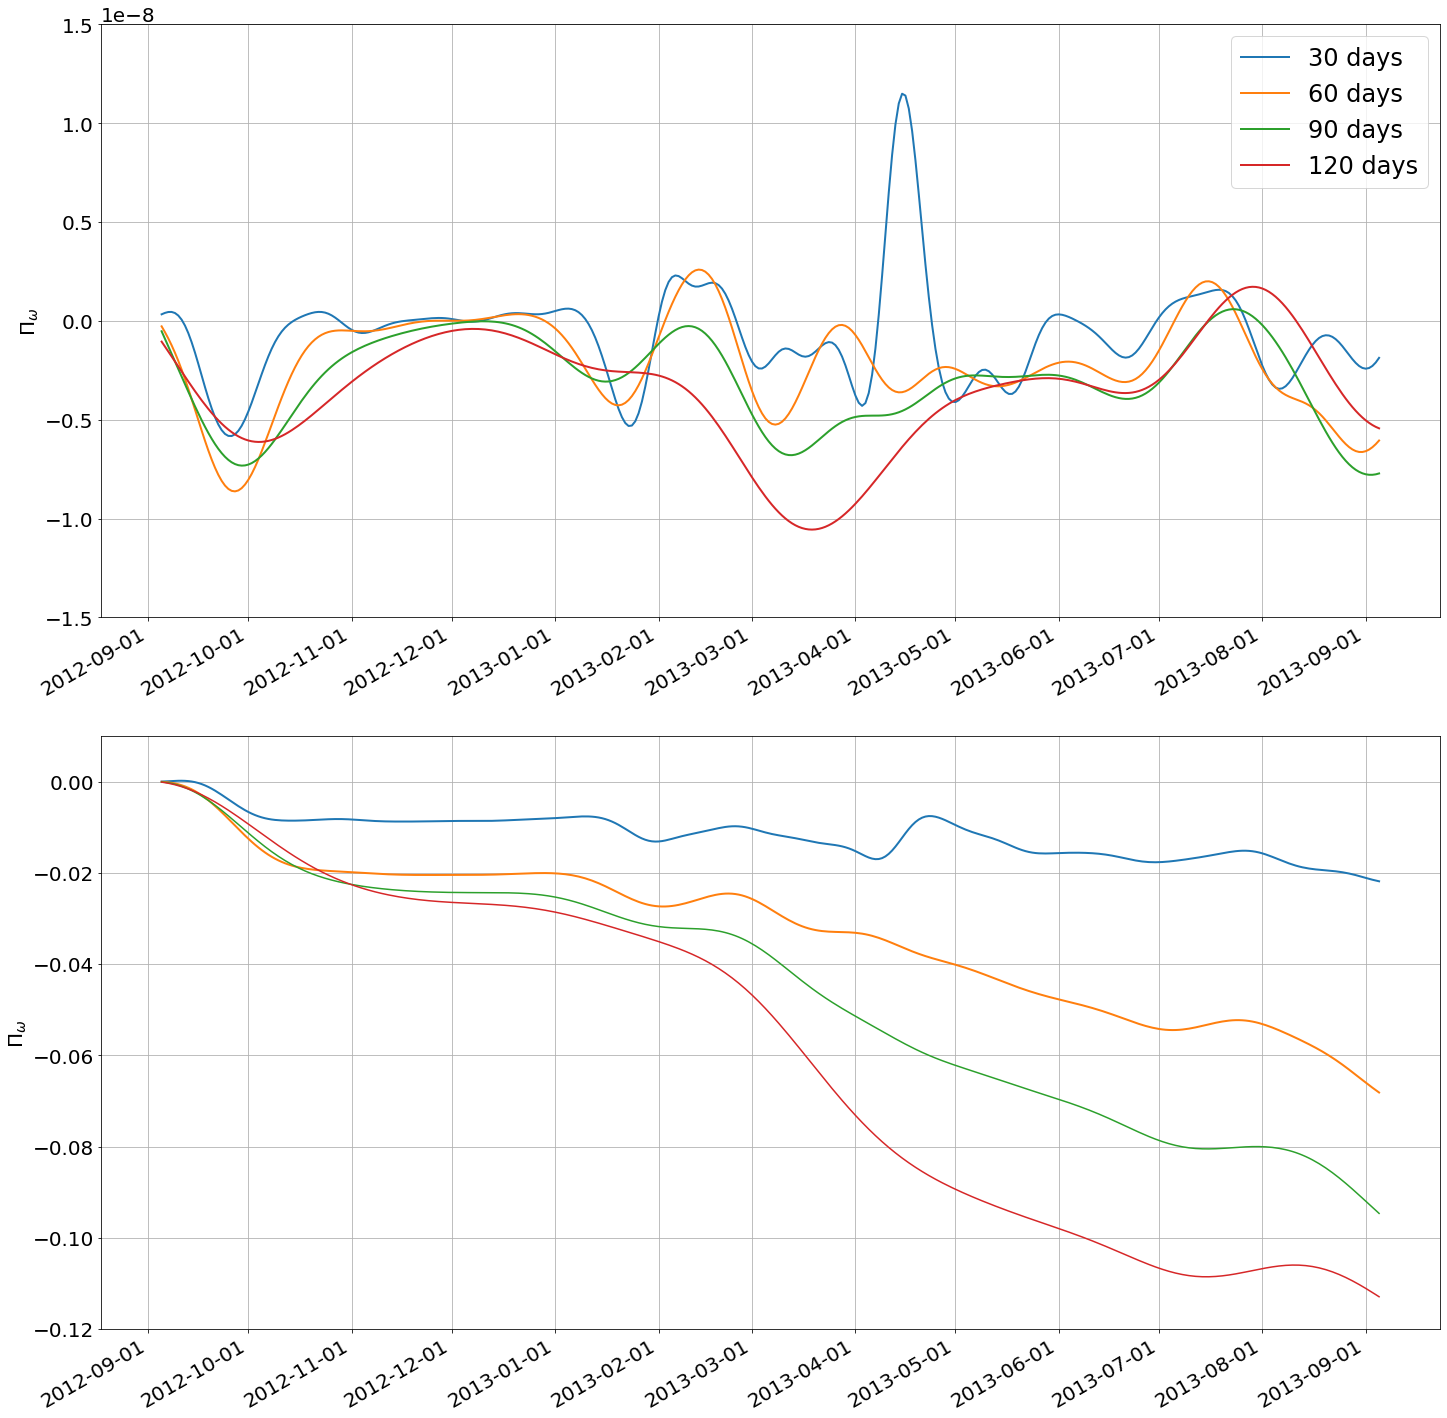

In [45]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(24,24))
labels = ['30 days', '60 days','90 days','120 days']

ax = plt.subplot(211)
PI_cg_sigma_030.PI_cg.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot(label=labels[0], linewidth=2)
PI_cg_sigma_060.PI_cg.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot(label=labels[1], linewidth=2)
PI_cg_sigma_090.PI_cg.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot(label=labels[2], linewidth=2)
PI_cg_sigma_120.PI_cg.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot(label=labels[3], linewidth=2)

ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
ax.set_ylim([-1.5*1e-8, 1.5*1e-8])
ax.set_xticks(['2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09'])
ax.set_title('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('$\Pi_{\omega}$',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(212)
PI_cg_30_cumsum.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot(linewidth=2)
PI_cg_60_cumsum.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot(linewidth=2)
PI_cg_90_cumsum.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot()
PI_cg_120_cumsum.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5')).plot()
ax.grid()
ax.set_ylim([-0.12, 0.01])
ax.set_xticks(['2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01'])
ax.set_xlabel('',fontsize=font_size)
ax.set_title('',fontsize=font_size)
ax.set_ylabel('$\Pi_{\omega}$',fontsize=font_size)
ax.tick_params(labelsize=font_size)

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_coarse_graining_long_periods3.png')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


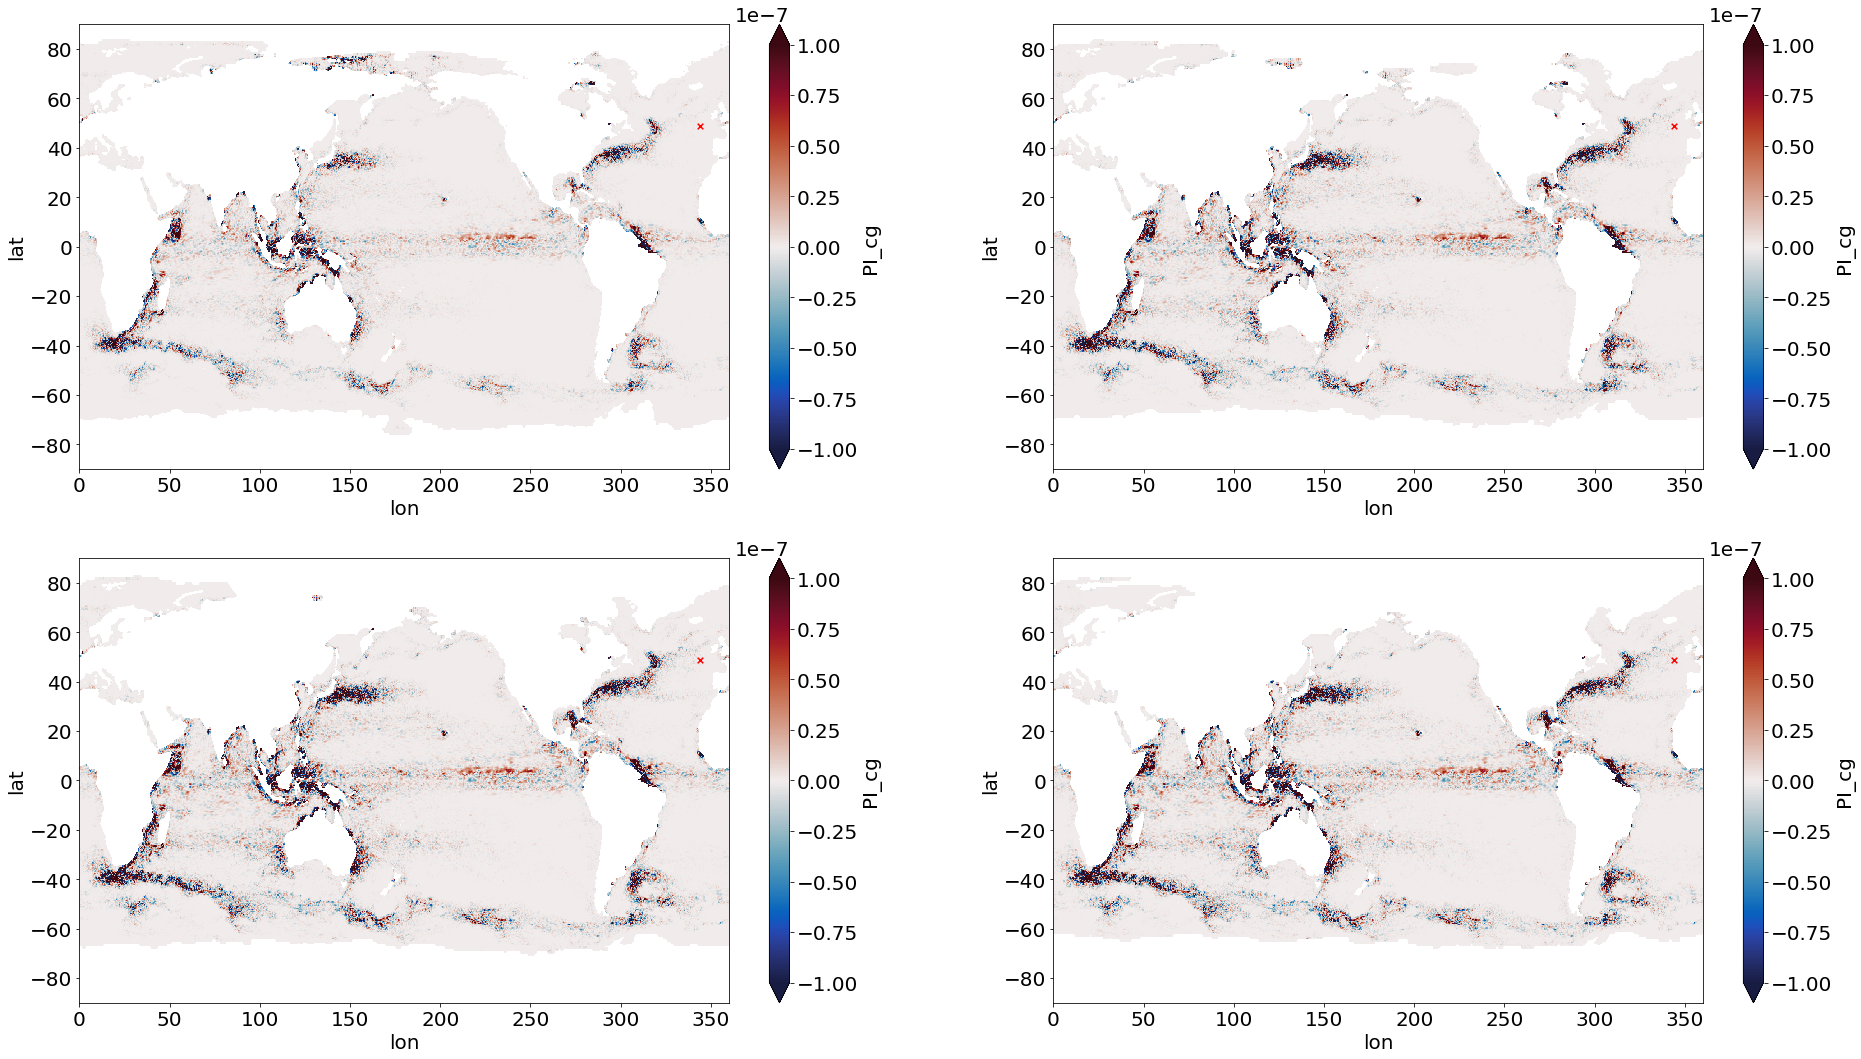

In [46]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(32,18))

ax = plt.subplot(221)
PI_cg_sigma_030.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-7,vmax=1e-7,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
PI_cg_sigma_060.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-7,vmax=1e-7,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
PI_cg_sigma_090.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-7,vmax=1e-7,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
PI_cg_sigma_120.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-7,vmax=1e-7,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_coarse_graining_long_periods4.png')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


(330.0, 360.0)

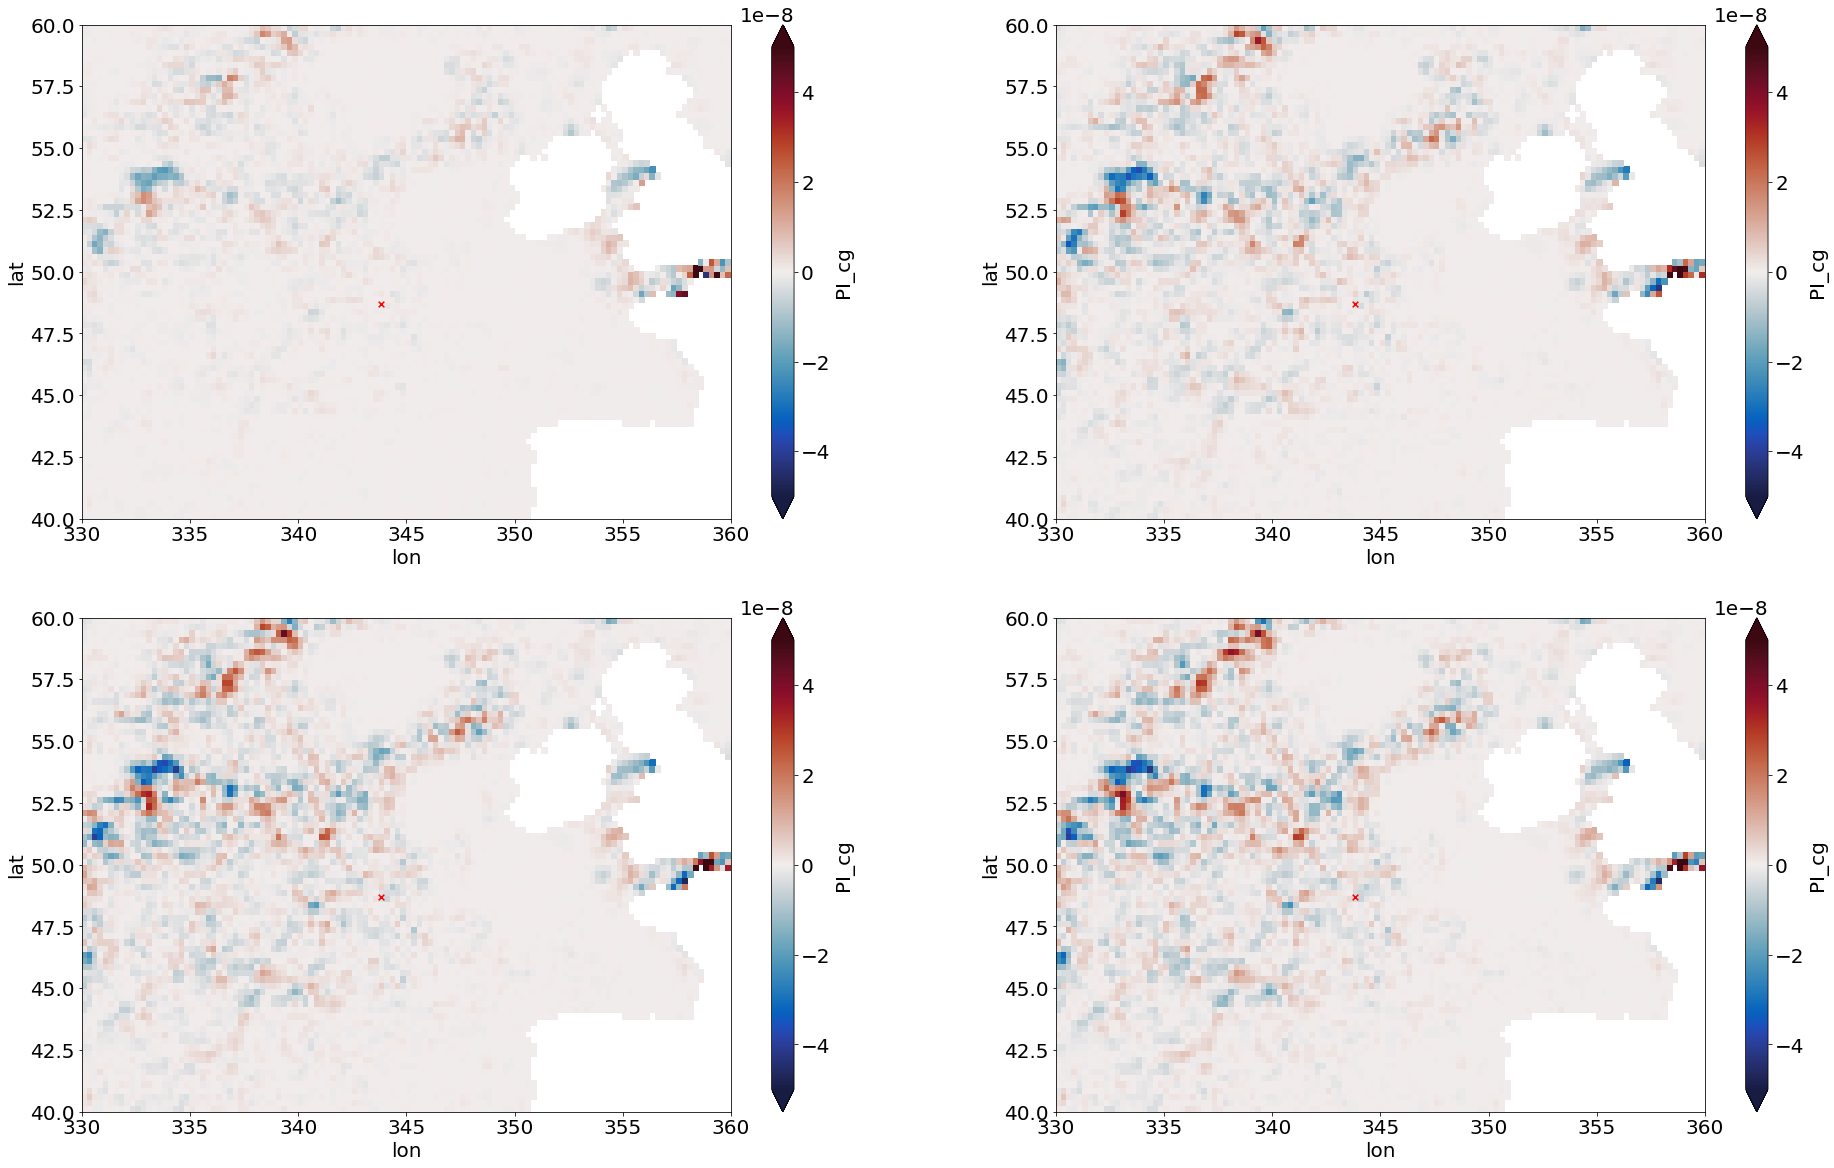

In [47]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(32,20))

ax = plt.subplot(221)
PI_cg_sigma_030.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-5e-8,vmax=5e-8,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([40., 60.])
ax.set_xlim([330., 360.])

ax = plt.subplot(222)
PI_cg_sigma_060.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-5e-8,vmax=5e-8,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([40., 60.])
ax.set_xlim([330., 360.])

ax = plt.subplot(223)
PI_cg_sigma_090.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-5e-8,vmax=5e-8,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([40., 60.])
ax.set_xlim([330., 360.])

ax = plt.subplot(224)
PI_cg_sigma_120.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-5e-8,vmax=5e-8,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([40., 60.])
ax.set_xlim([330., 360.])

(250.0, 360.0)

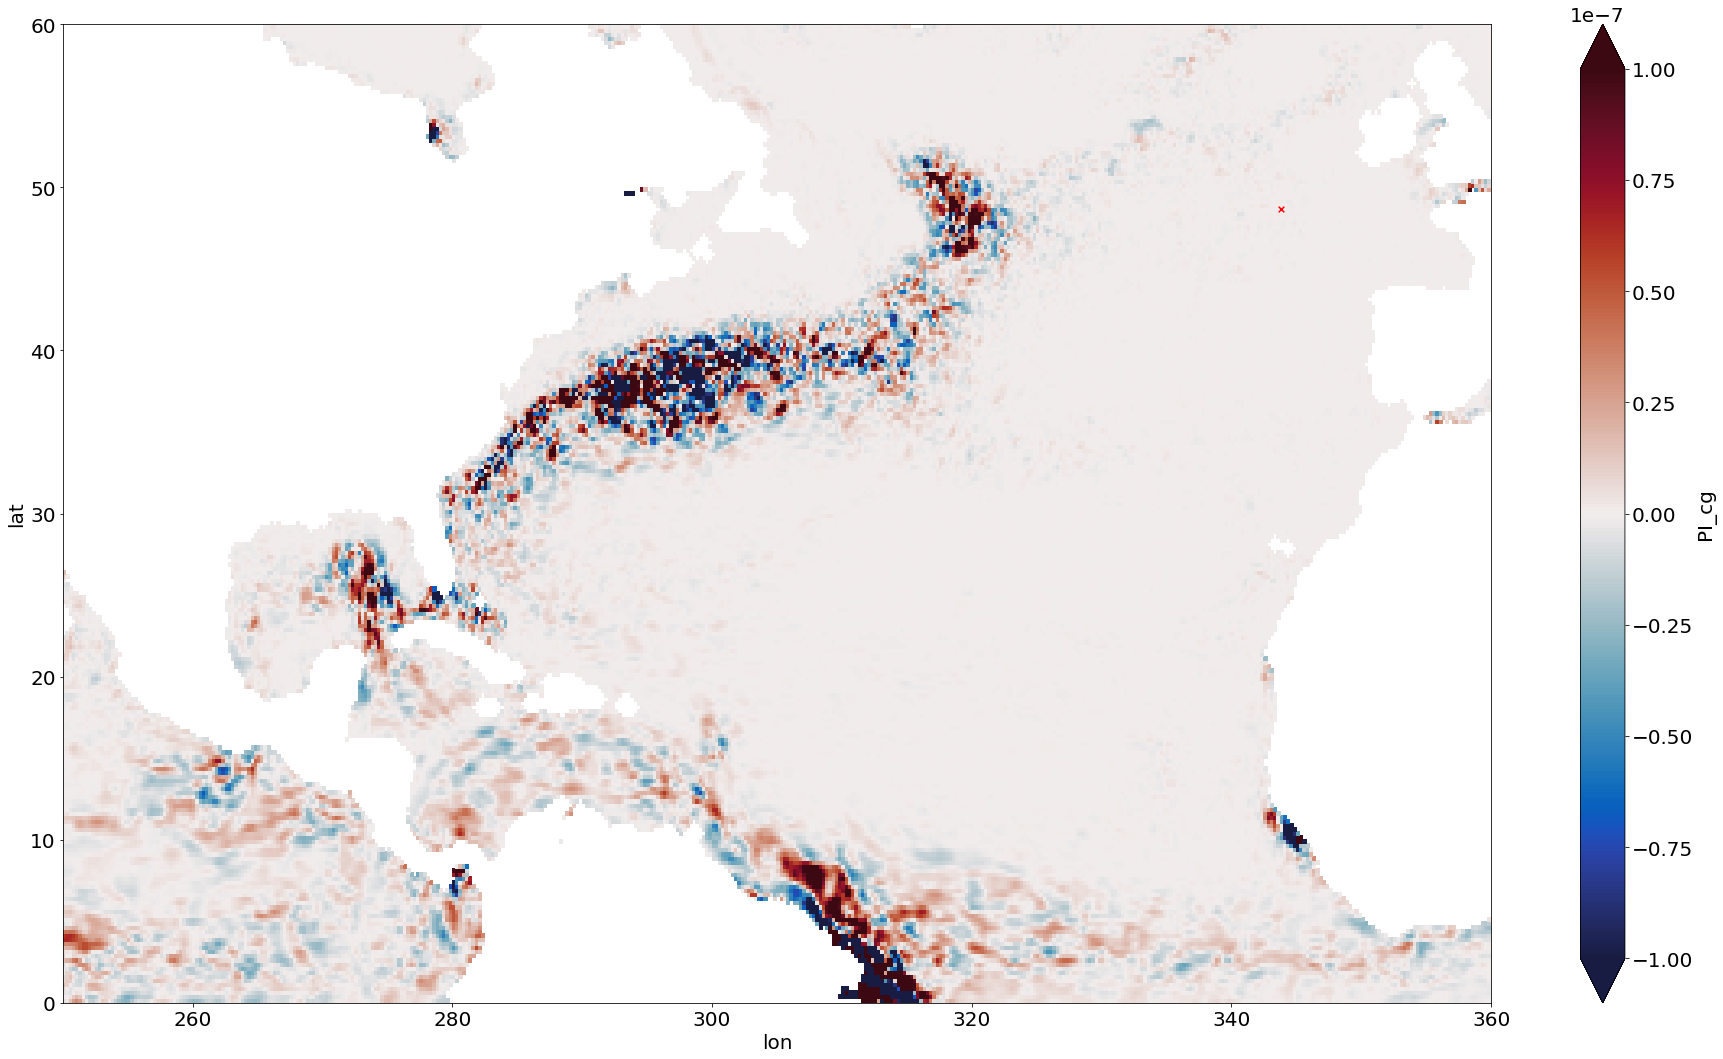

In [48]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(32,18))

ax = plt.subplot(111)
PI_cg_sigma_030.PI_cg.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=-1e-7,vmax=1e-7,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([00., 60.])
ax.set_xlim([250., 360.])


In [49]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1